In [1]:
import os
import gc
import csv
import sys
import time
import h5py
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
# from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from scipy.stats import pearsonr
import pickle 

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

In [2]:
_ = np.array([0, 2, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 33, 35, 37, 39, 41, 43, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 4, 5, 6, 7, 8, 9, 10, 11, 28, 45])
# read the fiber name
l_idx = [1,3,13,15,17,19,25,27,30,32,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
r_idx = [2,4,14,16,18,24,26,28,31,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72]
m_idx = [4,5,6,7,8,9,10,11]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]
label_name_lm = [label_name[l_idx[i]] for i in range(len(l_idx))] + [label_name[m_idx[i]] for i in range(len(m_idx))]
print(f'the number of fiber: {len(label_name_lm)}')

new_fiber_idx = []
for fi,ff in enumerate(_):
    if ff in list(l_idx)+list(m_idx): new_fiber_idx.append(fi)
new_fiber_idx = np.array(new_fiber_idx)
print(new_fiber_idx.shape)

the number of fiber: 36
(36,)


In [3]:
# the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

In [4]:
surface_name = 'white'

# Figure 3A.

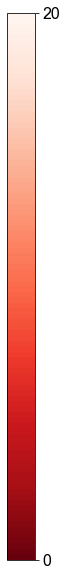

In [5]:
import matplotlib as mpl

def colorbar_noedge(vvmin, vvmax, cmap="coolwarm", nbins=5, ticks=[0]):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
   
    norm = mpl.colors.Normalize(vmin=vvmin, vmax=vvmax) 
    cb1 = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax,
        orientation="horizontal")

    tick_locator = mpl.ticker.MaxNLocator(nbins=nbins)  # colorbar上的刻度值个数
    cb1.locator = tick_locator
    cb1.outline.set_visible(False)
    cb1.set_ticks(ticks)
    cb1.ax.tick_params(labelsize=16)  #设置色标刻度字体大小。
    cb1.update_ticks()
    # cb1.set_label('',fontdict=font1) #设置colorbar的标签字体及其大小


def colorbar(vvmin, vvmax, cmap="coolwarm", nbins=5, ticks=[0], orientation="vertical", edge_visible=False, length=6):
    if orientation=="vertical":
        fig, ax = plt.subplots(figsize=(0.5, length))  
    elif orientation=="horizontal":
        fig, ax = plt.subplots(figsize=(length, 1)) 
    fig.subplots_adjust(bottom=0.5)
   
    norm = mpl.colors.Normalize(vmin=vvmin, vmax=vvmax) 
    cb1 = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax,
        orientation=orientation)   # "horizontal"

    tick_locator = mpl.ticker.MaxNLocator(nbins=nbins)  # colorbar上的刻度值个数
    cb1.locator = tick_locator
    cb1.outline.set_visible(edge_visible)
    cb1.set_ticks(ticks)
    cb1.ax.tick_params(labelsize=16)  #设置色标刻度字体大小。
    cb1.update_ticks()
    # cb1.set_label('',fontdict=font1) #设置colorbar的标签字体及其大小

# 离散化 colormap
def seq_colormap(c_map=plt.cm.bwr, nbins=5, half_split=False, reverse=False, left_one=False):
    # extract all colors from the .bwr map
    cmaplist = np.array([c_map(i) for i in range(c_map.N)])
    if half_split:
        selected_color = cmaplist[(np.linspace(0, 128, nbins)).astype(int)]
    else:
        selected_color = cmaplist[(np.linspace(0, 255, nbins)).astype(int)]
    if left_one:
        selected_color = np.concatenate((selected_color[1:, :], selected_color[0, :].reshape(1, -1)), axis=0)
        
    if reverse:
        return mpl.colors.ListedColormap(selected_color[::-1])
    else:
        return mpl.colors.ListedColormap(selected_color)


def seq_colormap_2(c_map=plt.cm.bwr, nbins=5, half_split=False, reverse=False, left_one=False):
    # extract all colors from the .bwr map
    cmaplist = np.array([c_map(i) for i in range(c_map.N)])
    if half_split:
        selected_color = cmaplist[(np.linspace(0, 110, nbins)).astype(int)]
    else:
        selected_color = cmaplist[(np.linspace(0, 255, nbins)).astype(int)]
    if left_one:
        selected_color = np.concatenate((selected_color[1:, :], selected_color[0, :].reshape(1, -1)), axis=0)
        
    if reverse:
        return mpl.colors.ListedColormap(selected_color[::-1])
    else:
        return mpl.colors.ListedColormap(selected_color)
    
red_seq_cmap = seq_colormap(c_map=plt.cm.Reds, 
                            nbins=100, 
                            half_split=False, 
                            reverse=True, 
                            left_one=False)
colorbar(0, 20, cmap=red_seq_cmap, nbins=100, ticks=[0, 20], edge_visible=True, length=20)
plt.savefig(f'./colorbar_Reds.jpg', dpi=300, bbox_inches="tight") 
# plt.savefig(f'./colorbar_YlGnBu.jpg', dpi=300, bbox_inches="tight") 

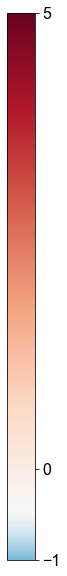

In [9]:
#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Arial',
'weight' : 'bold',
'size'   : 100,
}
c_map = plt.cm.Greens

# Left
nmf_r = np.array([i for i in range(100)]) / 100
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='RdBu_r')
colors_l = map_vir(norm_values)[::-1]

# Right
nmf_r = np.array([i for i in range(20)]) / 20
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='RdBu')
colors_r = map_vir(norm_values)
colors_r = colors_r[0:10,:]

colors = np.concatenate((colors_l, colors_r), axis=0)[::-1,:]

# create the new map
cm_custom = c_map.from_list('Custom c_map', colors, c_map.N)

colorbar(-1, 5, cmap=cm_custom, nbins=4, ticks=[-1, 0, 5],edge_visible=True, length=20)
plt.savefig(f'./colorbar_RdBu_r_my.png', dpi=300, bbox_inches="tight") 

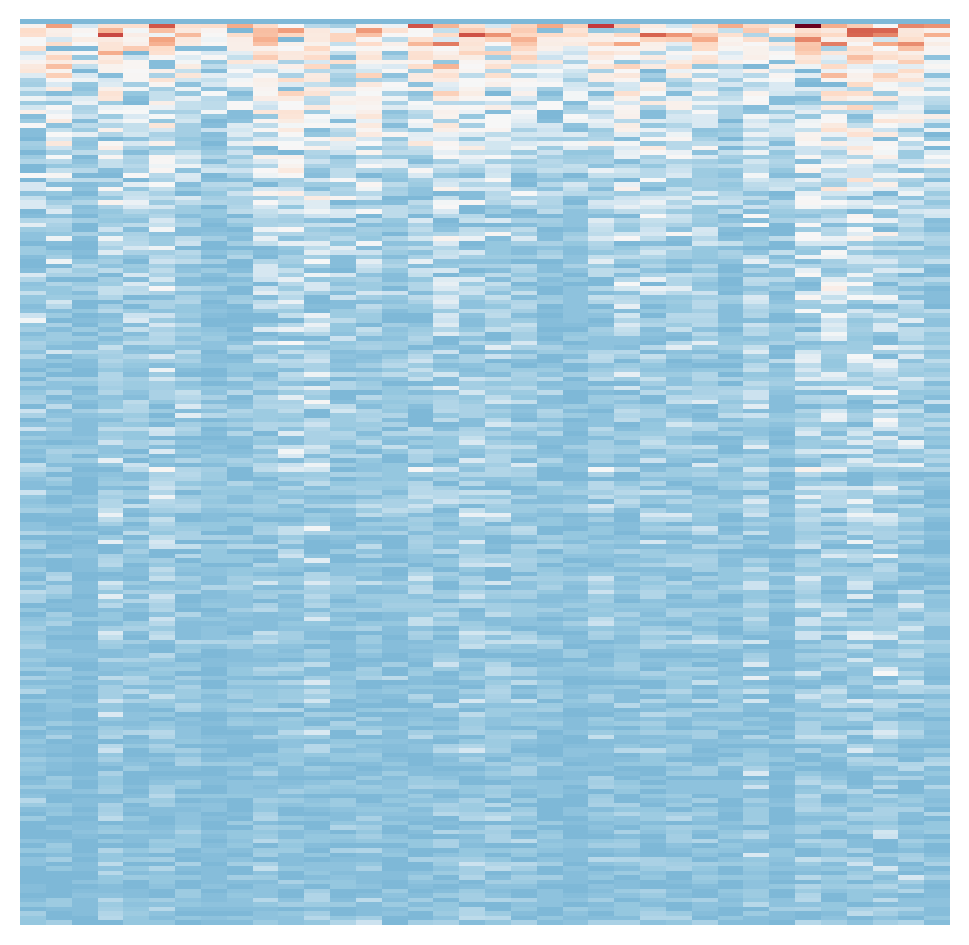

In [10]:
# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

para_mean = np.zeros((200,36))
for i,subi in enumerate(namelist):
    para = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{subi}/FP_{subi}_predict_by_200_group_geometrymode_para_L.npy')[:,new_fiber_idx]
    para_mean += para
para_mean = para_mean/len(namelist)

f, ax= plt.subplots(figsize = (6, 6), dpi=200)
df = pd.DataFrame(np.abs(para_mean), columns=[i for i in range(36)], index=[i for i in range(200)])
fig = sns.heatmap(df, cmap=cm_custom, # YlGnBu
                  annot=False,
                  cbar=False, 
                  annot_kws={'size':15})
plt.xticks([])
plt.yticks([])
ax.tick_params(labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha = 'right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha = 'right')
fig = fig.get_figure()
fig.show()

# Figure 3B.

(36,)


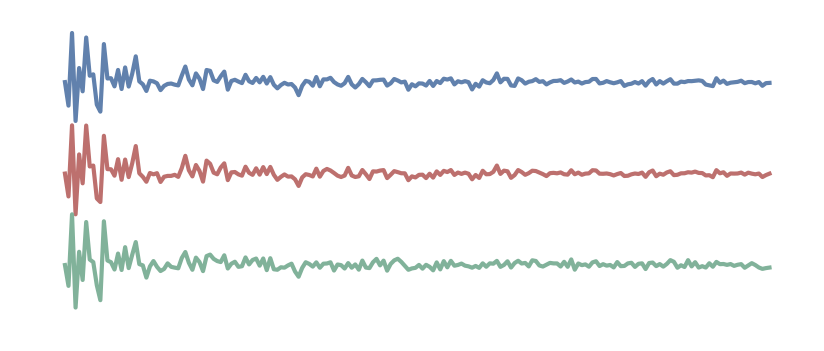

In [30]:
import pandas as pd
import seaborn as sns

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

fiber_label_colormap = ['#bd706e', '#6181ad', '#bd706e', '#6181ad', '#6181ad']
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,
              3,4,4,1,1,1,1,4,4,4,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1
fiber_label_lm = np.array(list(fiber_label[l_idx]) + list(fiber_label[m_idx]))
print(fiber_label_lm.shape)
palette_fiber = [fiber_label_colormap[fiber_label_lm[i]] for i in range(len(label_name_lm))]

sub = namelist[0]
fiber1 = label_name_lm.index('SLF_I')
fiber2 = label_name_lm.index('AF')
para1 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_whitemode_para_L.npy')
para2 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/retest/{sub}/FP_{sub}_predict_by_200_group_whitemode_para_L.npy')

sub = namelist[3]
para3 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_whitemode_para_L.npy')

plt.figure(figsize=(5, 2),dpi=200)
ax1 = plt.gca()
plt.plot(para1[0:200, fiber2], color='#6181ad',)
plt.plot(para2[0:200, fiber2]-0.05, color='#bd706e',)
plt.plot(para3[0:200, fiber2]-0.05-0.05, color='#81B29A',)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

(36,)


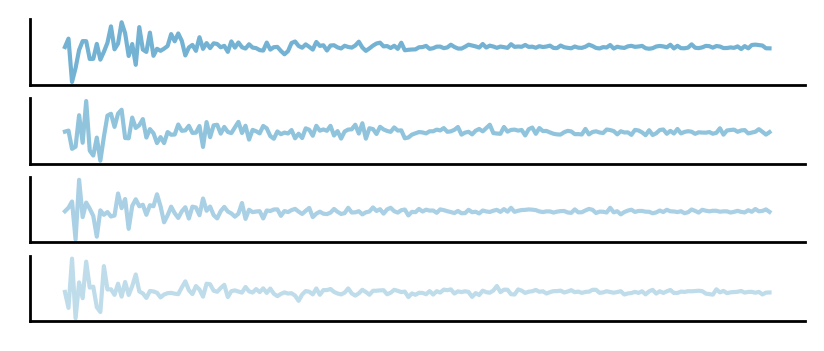

In [51]:
import pandas as pd
import seaborn as sns

def RGB_to_Hex(rbg):
    color = "#"
    for i in rbg:
        num = int(i*255)
        color += str(hex(num))[-2:].replace('x', '0').upper()
    # print(color)
    return color

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

fiber_label_colormap = ['#bd706e', '#6181ad', '#bd706e', '#6181ad', '#6181ad']
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,
              3,4,4,1,1,1,1,4,4,4,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1
fiber_label_lm = np.array(list(fiber_label[l_idx]) + list(fiber_label[m_idx]))
print(fiber_label_lm.shape)
palette_fiber = [fiber_label_colormap[fiber_label_lm[i]] for i in range(len(label_name_lm))]

sub = namelist[0]
fiber1 = label_name_lm.index('SLF_I')
fiber2 = label_name_lm.index('SLF_II')
fiber3 = label_name_lm.index('SLF_III')
fiber4 = label_name_lm.index('AF')
para1 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_whitemode_para_L.npy')

fig = plt.figure(figsize=(5, 2), dpi=200)
ax1 = fig.add_subplot(411)
plt.plot(para1[0:200, fiber1], 
        color=RGB_to_Hex(colors[0,:]),
        ) # '#6181ad'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(412)
plt.plot(para1[0:200, fiber2], 
        color=RGB_to_Hex(colors[3,:]),
        ) # '#bd706e'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(413)
plt.plot(para1[0:200, fiber3], 
        color=RGB_to_Hex(colors[6,:]),
        ) # '#81B29A'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(414)
plt.plot(para1[0:200, fiber4], 
        color=RGB_to_Hex(colors[9,:]),
        ) # '#EDC88C'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

plt.show()

# Figure 3C.

The h2 was calculated by APACE

Ref link: https://www.nisox.org/Software/APACE/ 

Ref title: Faster Accelerated Permutation Inference for the ACE Model (APACE) with Parallelization

In [8]:
twin_list = pd.read_csv('/n01dat01/dyli/multi/results_data/APACE/m02_HCPtwins_dyli.csv')
namelist_new = list(twin_list['SubjectID'])

m12 = np.zeros((len(namelist_new), 7200))
for i,subi in enumerate(namelist_new):
    pathi = f'/n01dat01/dyli/multi/HCP_1200/{subi}/FP_{subi}_predict_by_200_group_{surface_name}mode_deve-mode_thr05_para_L.npy'
    if not os.path.exists(pathi):
        print(subi)
    else:
        parai = np.load(pathi)[:, new_fiber_idx]
        parai = parai/np.max(parai, axis=0)
        m12[i,:] = parai.flatten()
df = pd.DataFrame(m12, columns=None, index=None)
df.to_csv(f'/n01dat01/dyli/multi/results_data/APACE/m12_FDI_lh.csv', header=None, index=None)

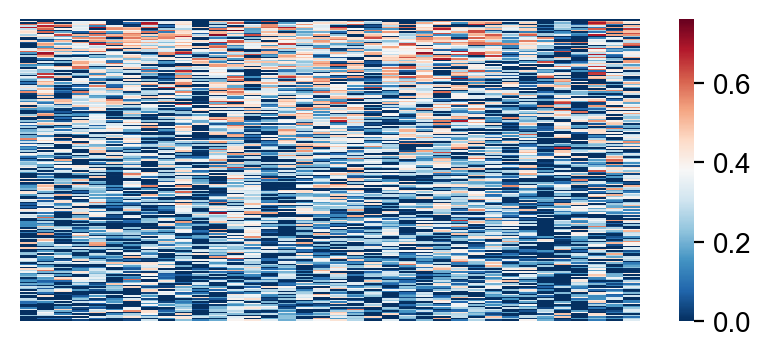

In [46]:
FDI_h2 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)

plt.figure(figsize=(5, 2),dpi=200)
ax1 = plt.gca()
sns.heatmap(FDI_h2, cmap='RdBu_r')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

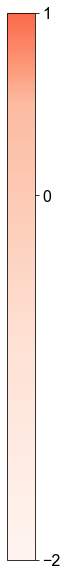

In [52]:
# Left
nmf_r = np.array([i for i in range(40)]) / 40
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='Reds_r')
colors_l = map_vir(norm_values)
colors_l = colors_l[0:20,:]

# Right
nmf_r = np.array([i for i in range(200)]) / 200
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='Reds_r')
colors_r = map_vir(norm_values)
colors_r = colors_r[100:,:]

colors = np.concatenate((colors_l, colors_r), axis=0)[::-1,:]

# create the new map
cm_custom = c_map.from_list('Custom c_map', colors, c_map.N)

colorbar(-2, 1, cmap=cm_custom, nbins=4, ticks=[-2, 0, 1],edge_visible=True, length=20)
plt.savefig(f'./colorbar_RdBu_r_my4h2.png', dpi=300, bbox_inches="tight") 

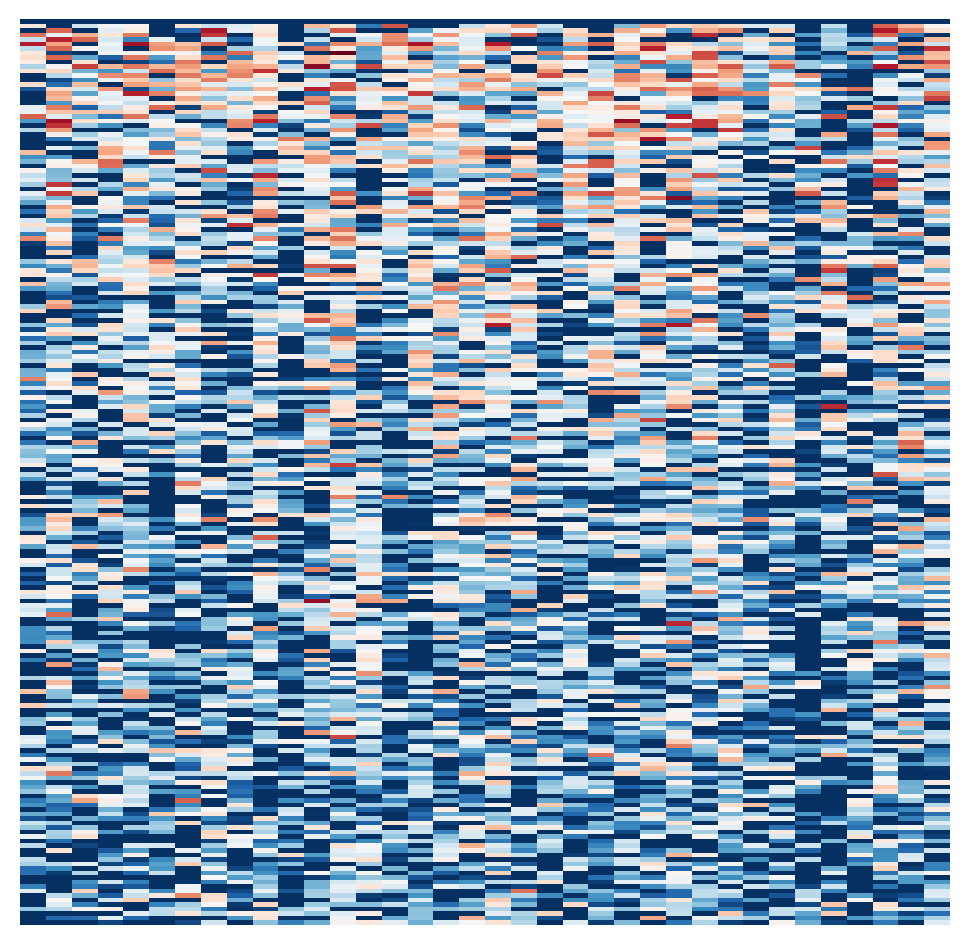

In [60]:
FDI_h2 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)

plt.figure(figsize=(6,6),dpi=200)
ax1 = plt.gca()
sns.heatmap(FDI_h2, 
            cmap='RdBu_r',# cm_custom,
            cbar=False) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

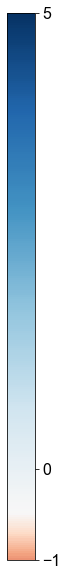

In [55]:
#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Arial',
'weight' : 'bold',
'size'   : 100,
}
c_map = plt.cm.Greens

# Left
nmf_r = np.array([i for i in range(100)]) / 100
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='RdBu')
colors_l = map_vir(norm_values)[::-1]
# colors_l = colors_l[0:50,:]

# Right
nmf_r = np.array([i for i in range(20)]) / 20
norm = plt.Normalize(-1,1)
norm_values = norm(nmf_r)
map_vir = plt.cm.get_cmap(name='RdBu_r')
colors_r = map_vir(norm_values)
colors_r = colors_r[0:10,:]

colors = np.concatenate((colors_l, colors_r), axis=0)[::-1,:]

# create the new map
cm_custom = c_map.from_list('Custom c_map', colors, c_map.N)

colorbar(-1, 5, cmap=cm_custom, nbins=4, ticks=[-1, 0, 5],edge_visible=True, length=20)

(36,)


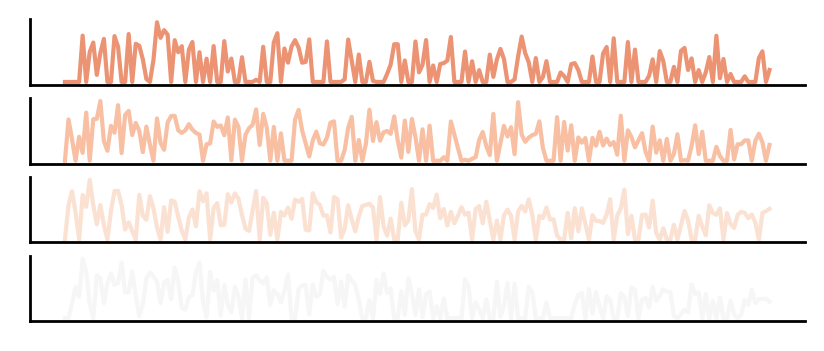

In [63]:
import pandas as pd
import seaborn as sns

def RGB_to_Hex(rbg):
    color = "#"
    for i in rbg:
        num = int(i*255)
        color += str(hex(num))[-2:].replace('x', '0').upper()
    # print(color)
    return color

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

fiber_label_colormap = ['#bd706e', '#6181ad', '#bd706e', '#6181ad', '#6181ad']
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,
              3,4,4,1,1,1,1,4,4,4,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1
fiber_label_lm = np.array(list(fiber_label[l_idx]) + list(fiber_label[m_idx]))
print(fiber_label_lm.shape)
palette_fiber = [fiber_label_colormap[fiber_label_lm[i]] for i in range(len(label_name_lm))]

sub = namelist[0]
fiber1 = label_name_lm.index('SLF_I')
fiber2 = label_name_lm.index('SLF_II')
fiber3 = label_name_lm.index('SLF_III')
fiber4 = label_name_lm.index('AF')
para1 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)

fig = plt.figure(figsize=(5, 2), dpi=200)
ax1 = fig.add_subplot(411)
plt.plot(para1[0:200, fiber1], 
        color=RGB_to_Hex(colors[0,:]),
        ) # '#6181ad'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(412)
plt.plot(para1[0:200, fiber2], 
        color=RGB_to_Hex(colors[3,:]),
        ) # '#bd706e'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(413)
plt.plot(para1[0:200, fiber3], 
        color=RGB_to_Hex(colors[6,:]),
        ) # '#81B29A'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(414)
plt.plot(para1[0:200, 15], 
        color=RGB_to_Hex(colors[9,:]),
        ) # '#EDC88C'
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(True)
ax1.spines['left'].set_linewidth(True)
plt.xticks([])
plt.yticks([])

plt.show()

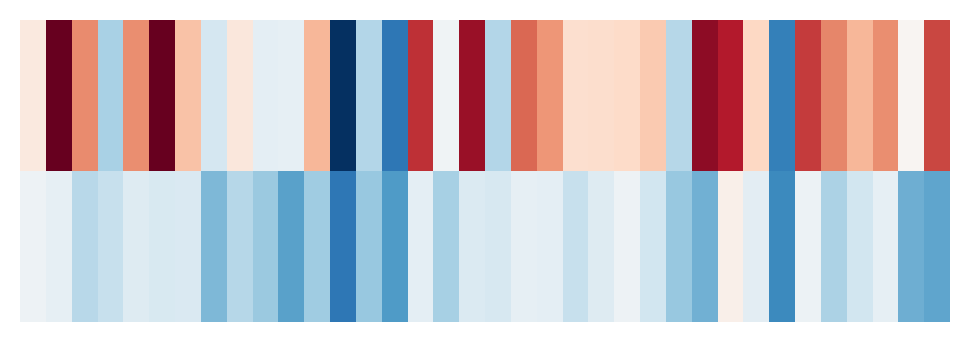

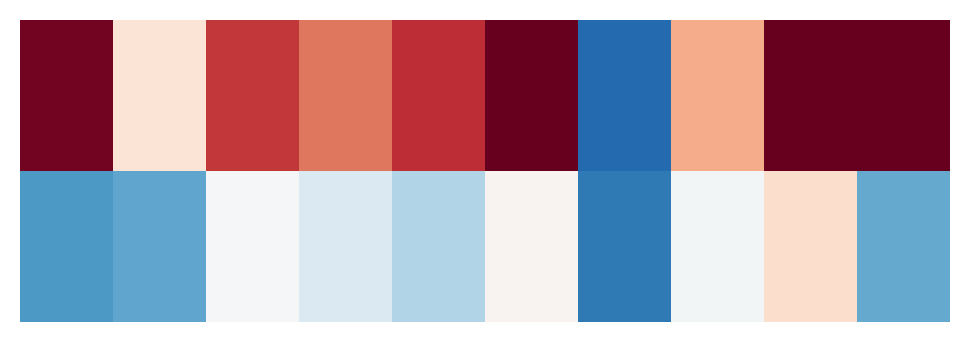

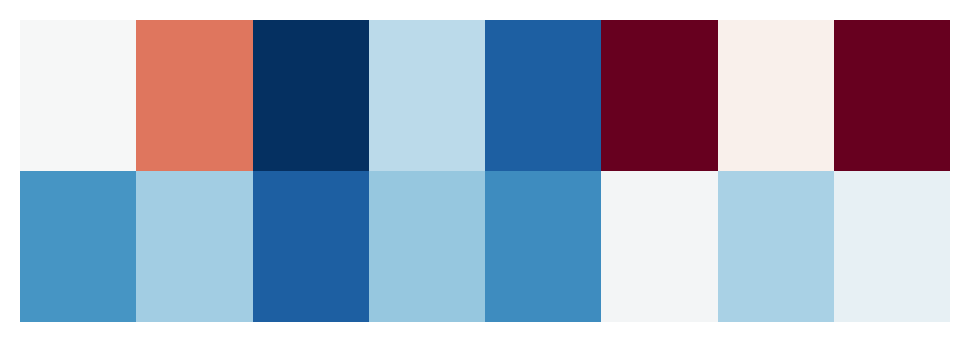

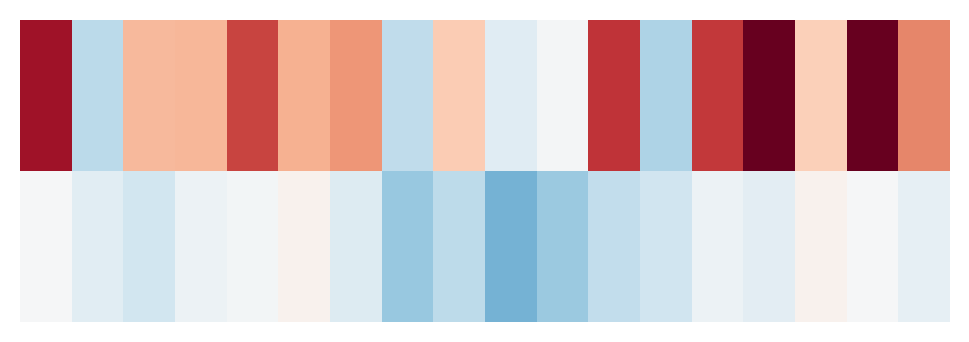

In [97]:
FDI_h2 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)
h2_new_ori = np.zeros((2,36))
for i in range(36):
    h2_new_ori[0,i] = np.mean(FDI_h2[1:10,i])
    h2_new_ori[1,i] = np.mean(FDI_h2[10:,i])

idx = np.argsort(fiber_label_lm)[::-1]
h2_new = h2_new_ori[:, idx]

plt.figure(figsize=(6,2),dpi=200)
ax1 = plt.gca()
sns.heatmap(h2_new, 
            cmap='RdBu_r',# cm_custom,
            cbar=False) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

# association
idx = np.argwhere(fiber_label_lm==0)
h2_new = np.squeeze(h2_new_ori[:, idx])
plt.figure(figsize=(6,2),dpi=200)
ax1 = plt.gca()
sns.heatmap(h2_new, 
            cmap='RdBu_r',# cm_custom,
            vmin=0.1,vmax=0.4,
            cbar=False) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

# commissural
idx = np.argwhere(fiber_label_lm==2)
h2_new = np.squeeze(h2_new_ori[:, idx])
plt.figure(figsize=(6,2),dpi=200)
ax1 = plt.gca()
sns.heatmap(h2_new, 
            cmap='RdBu_r',# cm_custom,
            vmin=0.1,vmax=0.4,
            cbar=False) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

# projection
idx = list(np.argwhere(fiber_label_lm==1)) + list(np.argwhere(fiber_label_lm==3)) + list(np.argwhere(fiber_label_lm==4))
h2_new = np.squeeze(h2_new_ori[:, idx])
plt.figure(figsize=(6,2),dpi=200)
ax1 = plt.gca()
sns.heatmap(h2_new, 
            cmap='RdBu_r',# cm_custom,
            vmin=0.1,vmax=0.4,
            cbar=False) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([])
plt.yticks([])
plt.show()

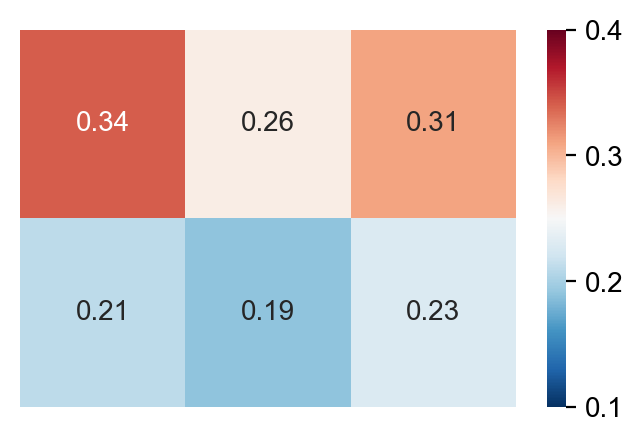

In [91]:
FDI_h2 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)
h2_new = np.zeros((2,3))

# association
idx = np.argwhere(fiber_label_lm==0)
h2_new[0,0] = np.mean(FDI_h2[1:10,idx])
h2_new[1,0] = np.mean(FDI_h2[10:,idx])
# commissural
idx = np.argwhere(fiber_label_lm==2)
h2_new[0,1] = np.mean(FDI_h2[1:10,idx])
h2_new[1,1] = np.mean(FDI_h2[10:,idx])
# projection
idx = list(np.argwhere(fiber_label_lm==1)) + list(np.argwhere(fiber_label_lm==3)) + list(np.argwhere(fiber_label_lm==4))
h2_new[0,2] = np.mean(FDI_h2[1:10,idx])
h2_new[1,2] = np.mean(FDI_h2[10:,idx])

plt.figure(figsize=(4,2.5),dpi=200)
ax1 = plt.gca()
sns.heatmap(h2_new, 
            cmap='RdBu_r',# cm_custom,
            # center=0,
            vmax=0.4,
            vmin=0.1,
            annot=True,
            cbar=True) # cm_custom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(False)
ax1.spines['left'].set_linewidth(False)
plt.xticks([],fontsize=20)
plt.yticks([],fontsize=20)
plt.show()

In [31]:
## for each region
FDI_h2 = np.loadtxt('/n01dat01/dyli/multi/results_data/APACE/h2.txt').reshape(200, 36)
FDI_h2_surface = np.mean(FDI_h2, axis=1)
print(FDI_h2_surface.shape)

# read the group MODE
x = np.loadtxt('/n01dat01/dyli/multi/support_code/BrainEigenmodes/data/template_eigenmodes/fsLR_32k_white-lh_emode_200.txt') # (32492, 200)

brain_map = np.zeros(32492)
for i in range(200):
    brain_map += FDI_h2_surface[i] * x[:, i]

(200,)


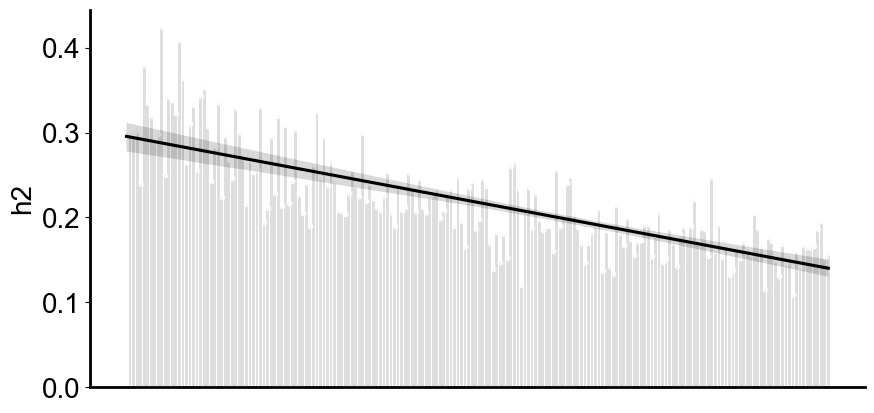

In [52]:
# mode contribution只看绝对值
x_weights_mode = FDI_h2_surface

df = pd.DataFrame(columns=['mode', 'mode contribution'])
for ii in range(200):
    #add row to end of DataFrame
    df.loc[len(df.index)] = [ii, x_weights_mode[ii]]

fig,ax = plt.subplots(figsize=(10,5),dpi=100,facecolor="w")

# palette = ['#81b29a' for i in range(200)]
palette = ['#dedede' for i in range(200)]
ax = sns.barplot(data=df,y='mode contribution',x='mode', # hue='feature_name',
                palette=palette,
                estimator=np.mean, ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                ax=ax,)
                # **{"edgecolor":"k","linewidth":1})
df['mode num'] = np.arange(0,200,1)
sns.regplot(data=df,
            y='mode contribution',
            x='mode num',
            scatter_kws={'s':10, 'color':'#ffffff'}, 
            line_kws={'linestyle':'solid', 'color':'black'})

plt.yticks(fontsize=20)
plt.xticks([],fontsize=20)
ax=plt.gca()
y_major_locator=MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('', fontsize=20)
plt.ylabel('h2', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
fig.savefig(f'figure3_mode_h2.png', transparent = True, bbox_inches = 'tight',dpi = 300)
plt.show()

In [45]:
pearsonr(FDI_h2_surface, np.arange(1,201,1))

(-0.7362995161681947, 1.9815769701522978e-35)

In [39]:
index_1 = FDI_h2_surface[0:8]
index_2 = FDI_h2_surface[8:]
t,p_two,_ = st.ttest_ind(index_1,index_2,) # usevar='unequal'
print(t, p_two)

2.588106681498895 0.010365838078305713
